# Colorspace - Ooze - Volumetric Graphs

Create png files based on the screen dump from the atari800 emulation of colourspace.

Download our modified version of the atari800 emulator. This will allow us to create dump files of screen memory at specified trace points while colourspace is running.

In [2]:
import os
! rm -rf atari800
! git clone https://github.com/mwenge/atari800.git
os.chdir('atari800')
! git checkout ooze
! ./autogen.sh
! ./configure --enable-monitormemorywatch
! make -j5
os.chdir('..')


Cloning into 'atari800'...
remote: Enumerating objects: 17549, done.
remote: Counting objects: 100% (1510/1510), done.
remote: Compressing objects: 100% (472/472), done.
remote: Total 17549 (delta 1069), reused 1422 (delta 1035), pack-reused 16039
Receiving objects: 100% (17549/17549), 5.75 MiB | 3.57 MiB/s, done.
Resolving deltas: 100% (13512/13512), done.
Branch 'ooze' set up to track remote branch 'ooze' from 'origin'.
Switched to a new branch 'ooze'
configure.ac:204: installing './compile'
configure.ac:73: installing './install-sh'
configure.ac:73: installing './missing'
src/Makefile.am: installing './depcomp'

Now you need to run the configure script.  The configure script may take the
"--target=TARGET" option and various "--enable-FEATURE" and "--with-PACKAGE"
options.

Run "./configure --help" to see all available options.
Run "./configure --help=short" just to see the Atari800 FEATURE options.
Run "./configure --target=help" without a parameter to see the valid targets.

checki

config.status: executing depfiles commands
-------------------------------------------------------
                 CONFIGURATION RESULTS:
-------------------------------------------------------
Host OS...............................: linux
Target ...............................: default

Interface for video...................: sdl
Using screenshots?....................: yes
    Supported screenshot formats......: pcx png
Using cycle exact?....................: yes
Using the very slow computer support?.: no
Using the crash menu?.................: yes
Using the paged attribute array?......: no
Using per opcode cycles update?.......: no
Using the buffered log?...............: no
Using Altirra BIOS ROM?...............: yes
Using the monitor assembler?..........: yes
Using code breakpoints and history?...: yes
Using user-defined breakpoints?.......: no
Using monitor hints?..................: yes
Using 6502 opcode profiling?..........: no
Using TRACE monitor command?..........: no
Using rea

Run the atari800 emulator and write the screen memory dumps to a file.

In [48]:
import os
os.chdir('../psychedelia')
! make colourspace_nodemo.xex
os.chdir('../notebooks')
# 4327 is the point at which we've finished a round of painting
! ./atari800/src/atari800 -memwatchbpc 4CE7 -memwatchfile colorspace_ooze_volumetric.txt ../psychedelia/bin/colourspace.xex

patch src/atari800/colourspace.asm -o src/atari800/colourspace_nodemo.asm < disable_demo.patch
patching file src/atari800/colourspace_nodemo.asm (read from src/atari800/colourspace.asm)
Hunk #1 succeeded at 4044 (offset 18 lines).
64tass -Wall -Wno-implied-reg --atari-xex -o bin/colourspace.xex -L bin/list-co1.txt -l bin/labels.txt src/atari800/colourspace_nodemo.asm
64tass Turbo Assembler Macro V1.56.2625?
64TASS comes with ABSOLUTELY NO WARRANTY; This is free software, and you
are welcome to redistribute it under certain conditions; See LICENSE!

Assembling file:   src/atari800/colourspace_nodemo.asm
Assembling file:   src/atari800/constants.asm
Assembling file:   src/atari800/patterns.asm
Assembling file:   src/atari800/presets.asm
Assembling file:   src/atari800/foreground.asm
Error messages:    None
Warning messages:  None
Passes:            3
Memory range:      $1f00-$7c66   $5d67
# the original xex file has an incorrect end-byte which we need to patch here.
dd if=bin/patch-atari

Read in the ram history from our dump file.

In [49]:
log_file = "colorspace_ooze_volumetric.txt"
input_file = open(log_file,'r')

flatten = lambda l: [e for sublist in l for e in sublist]

ram_history = []
lines = input_file.readlines()
for i in range(1, len(lines), 132):
    # Screen RAM (7000-8000)
    raw_ram = [l[6:126].split() for l in lines[i:i+104]]
    pixel_ram = [int(v,16) for l in raw_ram for v in l][:0x1000]
    # Display list (8000-9000)
    raw_ram = [l[6:126].split() for l in lines[i+103:i+127]]
    display_list = [int(v,16) for l in raw_ram for v in l]
    # Color Registers
    color_registers = [int(i,16) for i in lines[i+129].split()[1:10]]
    # Color and Ooze data
    ooze_registers = [int(i,16) for i in lines[i+130].split()[1:30]]
    ram_history += [(pixel_ram, color_registers, display_list, ooze_registers)]

Helper functions for implementing the display list entries

In [50]:
def getByteForAddress(address,scr):
    if 0x7000 <= address < 0x8000:
        return scr[address - 0x7000]
    return 0

def drawBlankLines(pixels, byte, y, num, scr):
    #pixels[x, y] = ImageColor.getrgb('#000000')
    return num

def drawScanLine(pixels, byte, y, num, scr):
    for x in range(0,40):
        byte = getByteForAddress(address+x, scr)
        left_nibble = byte >> 4 & 0x0F 
        right_nibble = byte & 0x0F
        for n in range(0,4):
            pixels[y][(x*8)+n] = col_register[left_nibble]
        for n in range(0,4):
            pixels[y][(x*8)+n+4] = col_register[right_nibble]
    return 1

dlist_dict = {
    0x70: (drawBlankLines,1,1),
    0x90: (drawBlankLines,1,1),
    0x46: (drawBlankLines,3,1),
    0x4F: (drawScanLine,  3,1),
}
def display_list_entry(dl):
    # Consume entries in the display list one by one.
    i = 0
    while i < len(dl):
        b = dl[i]
        if b not in dlist_dict:
            yield (None,None,None,None,None)
        draw, advance, lines = dlist_dict[b]
        address = (dl[i+2]<<8 | dl[i+1]) if advance > 1 else 0
        i += advance
        yield (b, draw, address, lines,i)


Read in the ram  history and paint a png file using the display lists and the pixel data.

In [51]:
ROWS = 192
COLS = 320

patterns = []
pixel_history = []
pooze = []
#selected = [ram_history[x] for x in [188,236]]
for j, (scr, col_register, display_list, ooze) in enumerate(ram_history):
    ooze = ooze[:8]
    pixels = [[0 for i in range(0,COLS)] for i in range(0,ROWS)]
    dlist = display_list_entry(display_list)
    x,y = 0,0
    while True:
        token, draw, address, num, i = next(dlist)
        if draw == None:
            break
        #print(hex(token),hex(address),num,i,display_list[i:i+2],len(display_list))
        y += draw(pixels, address, y, num, scr)
    if pooze and ooze != pooze:
        patterns += [(pooze,pixel_history)]
        pixel_history = []
    pooze = ooze
    pixel_history += [pixels]
patterns += [(pooze,pixel_history)]

len(patterns)

1

In [52]:
l = [(i,sum([1 if r > 1 else 0 for s in p for l in s for r in l])) 
     for (i,p) in patterns]
l.sort(key=lambda x: x[1])
l

[([0, 1, 1, 1, 1, 1, 1, 1], 49000)]

In [53]:
def firstNonZero(l):
    for i,e in enumerate(l):
        if e > 0:
            return i
    return i

def getLeftMostPixelForPattern(pattern):
    return min([firstNonZero(r) for scr in pattern for r in scr])

def getRightMostPixelForPattern(pattern):
    return len(pattern[0][0]) - min([firstNonZero(list(reversed(r)))
                     for scr in pattern for r in scr])

def rotatePatternToCols(pattern):
    pattern_cols = []
    for scr in pattern:
        col_arr = [[0 for i in range(len(scr))] for j in range(len(scr[0]))]
        for i,r in enumerate(scr):
            for j,v in enumerate(r):
                col_arr[j][i] = v
        pattern_cols += [col_arr]
    return pattern_cols

def cullPattern(pattern):
    first_left = getLeftMostPixelForPattern(pattern)
    last_right = getRightMostPixelForPattern(pattern)
    width = last_right - first_left

    pattern_as_cols = rotatePatternToCols(pattern)
    first_top = getLeftMostPixelForPattern(pattern_as_cols)
    last_bottom = getRightMostPixelForPattern(pattern_as_cols)
    height = last_bottom - first_top
    
    culled = [[r[first_left:last_right] 
              for r in scr[first_top:last_bottom]]
              for scr in pattern]
    return culled

#cullPattern(patterns[0])
#patterns[0]

In [54]:
from PIL import Image, ImageColor, ImageChops
from matplotlib.colors import LightSource
import colorspace_colors as cc
import numpy as np

def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

def createVoxelData(screens):
    # prepare some coordinates
    width = len(screens[0][0])
    height = len (screens[0])
    x, y, z = np.indices((width,height,len(screens)))
    voxelarray = np.zeros((width,height,len(screens)), dtype=bool)
    colorarray = np.empty(voxelarray.shape, dtype=object)
    for zp,screen in enumerate(screens):
        for yp, row in enumerate(list(reversed(screen))):
            for xp, col in enumerate(row):
                # Skip black, white and gray cells
                if col in [0,1,0x0c]:
                    continue
                cube = (x == xp) & (y == yp) & (z == zp)
                voxelarray |= cube
                color =  cc.color_value_to_html[col]
                colorarray[cube] = color+"c0"

    # upscale the above voxel image, leaving gaps
    filled_2 = explode(voxelarray)
    ecolors_2 = explode(colorarray)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.10
    y[:, 0::2, :] += 0.10
    z[:, :, 0::2] += 0.10
    x[1::2, :, :] += 0.90
    y[:, 1::2, :] += 0.90
    z[:, :, 1::2] += 0.90

    return ((x,y,z), filled_2, ecolors_2)

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

1 2024-02-13 18:32:17.883191 checking
1 2024-02-13 18:33:31.523059 createVoxelData
1 2024-02-13 21:21:52.190899 plot


KeyboardInterrupt: 

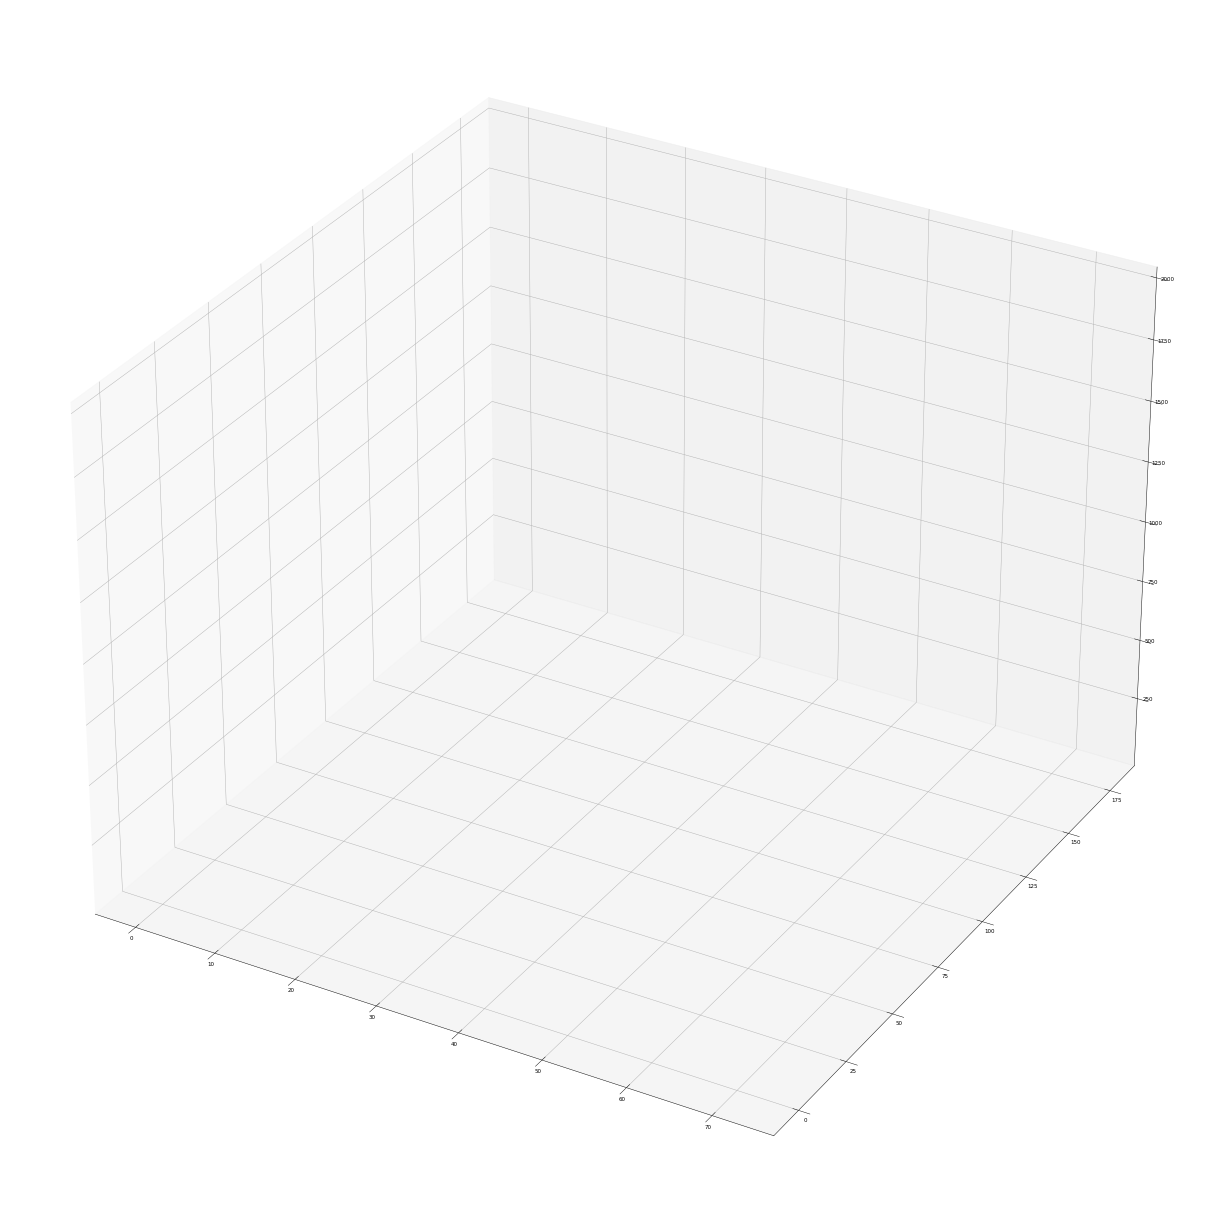

In [55]:
# Select our pattern
import os
import gc
import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)
plt.rcParams['figure.dpi'] = 40


def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    print(bbox)
    return im.crop(bbox)

for i, (pid_array,screens) in enumerate(patterns):
    for azim in [-45]:
        pid = int(pid_array[2])
        print(pid, datetime.datetime.now(), "checking")
        if os.path.isfile(f'colorspace_ooze/ooze_{pid}{azim}.png'):
            continue
        screens = cullPattern(screens)
        print(pid, datetime.datetime.now(), "createVoxelData")
        ((x,y,z), voxels, vcolors) = createVoxelData(screens)
        # and plot everything
        print(pid, datetime.datetime.now(), "plot")
        ax = plt.figure().add_subplot(projection='3d')
        ls = LightSource(45)
        ax.voxels(x,y,z,voxels, facecolors=vcolors, edgecolors=vcolors,lightsource=ls)
        ax.axis('off')
        ax.view_init(azim=azim, vertical_axis='y')
        print(pid, datetime.datetime.now(), "fig2img")
        img = fig2img(plt.gcf())
        img = img.resize((int(img.width / 2), int(img.height / 2)), Image.NEAREST)
        
        print(pid, datetime.datetime.now(), "remove alpha")
        newImage = []
        for item in img.getdata():
            if item[:3] == (255, 255, 255):
                newImage.append((255, 255, 255, 0))
            else:
                newImage.append(item)

        print(pid, datetime.datetime.now(), "write image")
        img.putdata(newImage)
        img = trim(img)
        img.save(f'colorspace_ooze/ooze_{pid}{azim}.png')
        plt.clf()
        del voxels, vcolors
        plt.close()
        gc.collect()
